# Seoul Bike Sharing Demand
Дані взято із [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand)

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat Feb 22 16:25:24 2025
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as pp
from sklearn import metrics

In [2]:
data = pd.read_excel('datasets\SeoulBikeData.xlsx', engine='openpyxl')

## EDA
Огляд особливостей датасету та візуалізації

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   8760 non-null   datetime64[ns]
 1   Rented Bike Count      8760 non-null   int64         
 2   Hour                   8760 non-null   int64         
 3   Temperature            8760 non-null   float64       
 4   Humidity               8760 non-null   int64         
 5   Wind speed             8760 non-null   float64       
 6   Visibility             8760 non-null   int64         
 7   Dew point temperature  8760 non-null   float64       
 8   Solar Radiation        8760 non-null   float64       
 9   Rainfall               8760 non-null   float64       
 10  Snowfall               8760 non-null   float64       
 11  Seasons                8760 non-null   object        
 12  Holiday                8760 non-null   object        
 13  Fun

In [4]:
data.isna().sum()

Date                     0
Rented Bike Count        0
Hour                     0
Temperature              0
Humidity                 0
Wind speed               0
Visibility               0
Dew point temperature    0
Solar Radiation          0
Rainfall                 0
Snowfall                 0
Seasons                  0
Holiday                  0
Functioning Day          0
dtype: int64

In [5]:
data['Date']

0      2017-12-01
1      2017-12-01
2      2017-12-01
3      2017-12-01
4      2017-12-01
          ...    
8755   2018-11-30
8756   2018-11-30
8757   2018-11-30
8758   2018-11-30
8759   2018-11-30
Name: Date, Length: 8760, dtype: datetime64[ns]

В даних немає пропусків. Присутні щогодинні записи за рівно 1 рік часу - з 1 грудня 2017 до 31 листопада 2018. 

Цих даних недостатньо, щоб відділити сезонність від тренду. Тому, хоча ці дані є часовим рядом, ми будемо аналізувати їх за допомогою регресії як незалежні спостереження. Так ми втрачаємо наявну інформацію про можливу сезонність, тренд та автокореляцію, але убезпечуємо себе від хибних висновків, які можна зробити на основі неповних даних.

**Візуалізуємо сезонність даних:**

In [6]:
data['Month'] = data['Date'].dt.month_name()
data['Day of week'] = data['Date'].dt.day_name()

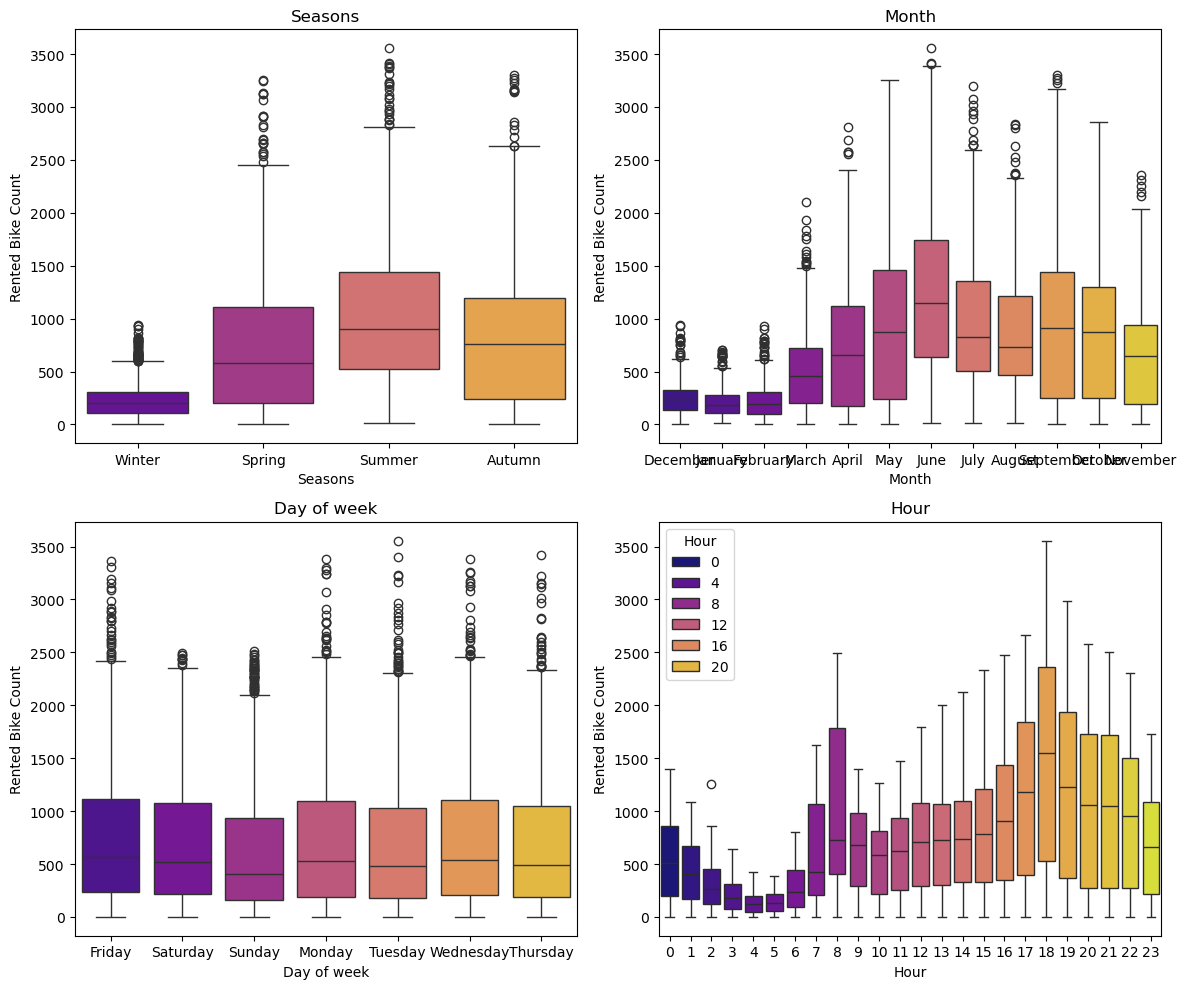

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for col, ax in zip(['Seasons', 'Month', 'Day of week', 'Hour'], axes.flatten()):
    sns.boxplot(data, x=col, y='Rented Bike Count', palette='plasma', hue=col, ax=ax)
    ax.set_title(col)
fig.tight_layout()

## Підготовка даних

### Узагальнення даних на дні

Надалі будемо використовувати денні суми взятих напрокат велосипеди замість погодинних даних. Так робити не обов'язково. Звісно, цей датасет можна аналізувати будь-яким із двох способів, в розрізі годин чи днів. 

Для цього задамо правила агрегації погодинних даних окремо для кожного пераметру. Це будуть суми для цільової змінної та кількості опадів, середні для решти погодних даних, та останнє значення для категоріальних змінних (можна брати перше - без різниці, так як значення цих змінних не змінюються протягом дня).

In [8]:
data_daily = data.groupby(data['Date']).agg({
    'Rented Bike Count': 'sum',	
    'Hour': 'last',	
    'Temperature': 'mean',
    'Humidity': 'mean',
    'Wind speed': 'mean', 
    'Visibility': 'mean',
    'Dew point temperature': 'mean',
    'Solar Radiation': 'mean',
    'Rainfall': 'sum', 
    'Snowfall': 'sum',
    'Seasons': 'last',
    'Month': 'last',
    'Day of week': 'last',
    'Holiday': 'last',
    'Functioning Day': 'last'
    }).reset_index().drop(['Hour', 'Date'], axis=1)

data_daily.describe()

,Rented Bike Count,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,16910.449315,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,3.568493,1.801644
std,10258.639202,11.555997,14.673269,0.601884,491.249597,12.808952,0.314487,11.846930,8.664456
min,0.000000,-14.737500,22.250000,0.662500,214.291667,-27.750000,0.029167,0.000000,0.000000
25%,6500.000000,3.812500,47.916667,1.295833,1087.541667,-4.862500,0.285417,0.000000,0.000000
50%,17730.000000,13.837500,57.208333,1.641667,1557.750000,5.008333,0.565000,0.000000,0.000000
75%,26075.000000,22.425000,67.541667,1.954167,1877.250000,14.570833,0.815833,0.500000,0.000000
max,36149.000000,33.741667,95.875000,4.000000,2000.000000,25.037500,1.216667,95.500000,78.700000


### Кодування категоріальних ознак

In [9]:
categorical_features = ['Seasons', 'Functioning Day', 'Holiday', 'Month', 'Day of week']
numerical_features = [col for col in data_daily.columns if col not in categorical_features]

for col in categorical_features:
    print(col, ":", data_daily[col].unique())

Seasons : ['Winter' 'Spring' 'Summer' 'Autumn']
Functioning Day : ['Yes' 'No']
Holiday : ['No Holiday' 'Holiday']
Month : ['December' 'January' 'February' 'March' 'April' 'May' 'June' 'July'
 'August' 'September' 'October' 'November']
Day of week : ['Friday' 'Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday' 'Thursday']


#### Перший спосіб - вручну через функцію `map` в `pandas`

In [10]:
data_daily['Functioning Day'] = data_daily['Functioning Day'].map({
    'No': 0,
    'Yes': 1})

#### Другий спосіб - через функцію `get_dummies` з бібліотеки `pandas`

In [11]:
seasons = pd.get_dummies(data_daily['Seasons'], drop_first=True).astype(int)
seasons.head()

,Spring,Summer,Winter
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


#### Третій спосіб - через клас `OneHotEncoder` з бібліотеки `scikit-learn`

In [12]:
encoder = pp.OneHotEncoder(drop='first', sparse_output=False).set_output(transform='pandas')
data_daily = pd.concat([data_daily, encoder.fit_transform(data_daily[categorical_features[2:]])], axis=1)

Тепер можемо видалити початкові текстові ознаки. Змінну із порою року ми викидаємо взагалі, так як її можна повністю замінити місяцем без втрати інформації.

In [13]:
data_daily.drop(['Holiday', 'Seasons', 'Month', 'Day of week'], inplace=True, axis=1)
data_daily.describe()

,Rented Bike Count,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Functioning Day,Holiday_No Holiday,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,Day of week_Monday,Day of week_Saturday,Day of week_Sunday,Day of week_Thursday,Day of week_Tuesday,Day of week_Wednesday
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,16910.449315,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,3.568493,1.801644,0.967123,0.950685,0.084932,0.084932,0.076712,0.084932,0.084932,0.082192,0.084932,0.084932,0.082192,0.084932,0.082192,0.142466,0.142466,0.142466,0.142466,0.142466,0.142466
std,10258.639202,11.555997,14.673269,0.601884,491.249597,12.808952,0.314487,11.846930,8.664456,0.178559,0.216822,0.279162,0.279162,0.266500,0.279162,0.279162,0.275034,0.279162,0.279162,0.275034,0.279162,0.275034,0.350007,0.350007,0.350007,0.350007,0.350007,0.350007
min,0.000000,-14.737500,22.250000,0.662500,214.291667,-27.750000,0.029167,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6500.000000,3.812500,47.916667,1.295833,1087.541667,-4.862500,0.285417,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,17730.000000,13.837500,57.208333,1.641667,1557.750000,5.008333,0.565000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,26075.000000,22.425000,67.541667,1.954167,1877.250000,14.570833,0.815833,0.500000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,36149.000000,33.741667,95.875000,4.000000,2000.000000,25.037500,1.216667,95.500000,78.700000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Поділ даних на тренувальну та тестову вибірки
Для часових рядів варто відділяти пізніші за часом дані для тестових - так ми зробимо валідацію моделі більш наближеною до реальної ситуації. Це стосується і тих ситуацій, коли ми аналізуємо дані без прив'язки до дат, як зараз. Проте в цьому датасеті наявний лише один рік даних; відділивши кілька останніх місяців для валідації, ми не зможемо дослідити сезонність у цей час. Тож будемо ділити дані випадковим чином.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    data_daily.drop(['Rented Bike Count'], axis=1), 
    data_daily['Rented Bike Count'],
    test_size=0.33, random_state=42)

### Масштабування даних
На цьому ж етапі зазвичай виконується і кодування категоріальних змінних. Тут ми могли виконати його раніше, бо знали, що наше кодування не допустить витоку даних.

In [15]:
scaler = pp.StandardScaler().set_output(transform='pandas')
numerical_variables = ['Temperature', 'Humidity', 'Wind speed',
       'Visibility', 'Dew point temperature', 'Solar Radiation', 'Rainfall',
       'Snowfall']
X_train[numerical_variables] = scaler.fit_transform(X_train[numerical_variables])
X_test[numerical_variables] = scaler.transform(X_test[numerical_variables])

## Лінійна регресія за бібліотекою `statsmodels`
Ця бібліотека дає дуже детальний фідбек щодо результатів навчання моделі. Його можна використовувати для визначення колінеарних та несуттєвих змінних.

In [16]:
import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train)
sm_model = sm.OLS(y_train, X_train_sm).fit()
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:      Rented Bike Count   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     82.89
Date:                Sat, 22 Feb 2025   Prob (F-statistic):           1.07e-98
Time:                        21:50:15   Log-Likelihood:                -2303.8
No. Observations:                 244   AIC:                             4664.
Df Residuals:                     216   BIC:                             4762.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -8572.86

Таблиця вище показує нам, які змінні в цій моделі можливо є зайвими. "Зайвим" змінним відповідає високий рівень зачущості статистики t (колонка `P>|t|`). Зазвичай високими вважається значення > 10% або > 5%. Це означає, що такі змінні повторюють інформацію з інших наявних змінних, або є несуттєвими для прогнозування цільової змінної.

Будемо видаляти такі змінні одна по одній, починаючи із найвищого рівня значущості, поки не отримаємо набір із лише "суттєвих" змінних. Точність моделі тут можемо оцінювати за метриками, що визначають близькість прилягання нашої лінійної моделі до справжніх значень - ці метрики розміщено в правій колонці першої таблиці (від $R^2$ до BIC). Найкраще тут орієнтуватися на метрику Adjusted $R^2$ - поправка тут стосується "штрафування" моделі за використання великої кількості вхідних змінних.

**Не обов'язково** використовувати значення статистики із таблиці як чіткий критерій вибору змінних. Це лише рекомендація, що базується на математиці навчання моделі.

In [17]:
delete_variables = ['Temperature', 'Month_July', 'Day of week_Wednesday', 
                    'Day of week_Tuesday', 'Day of week_Thursday', 'Day of week_Monday',
                    'Visibility', 'Snowfall']
sm_model = sm.OLS(y_train, X_train_sm.drop(delete_variables, axis=1)).fit()
print(sm_model.summary())

                            OLS Regression Results                            
Dep. Variable:      Rented Bike Count   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     118.1
Date:                Sat, 22 Feb 2025   Prob (F-statistic):          2.67e-105
Time:                        21:50:15   Log-Likelihood:                -2307.5
No. Observations:                 244   AIC:                             4655.
Df Residuals:                     224   BIC:                             4725.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -8040.36

## Навчання на валідаці моделі через `sklearn`

Метрика MAPE погано підходить для цього датасету, тому що значення цільової змінної можуть бути рівні 0 або близькими до нього. Через ділення на 0 будуть виникати значення `np.inf` або числа високих порядків. Як альтернативний спосіб отримувати точність моделі у %, можна використати метрику normalized RMSE (nRMSE).

In [18]:
model = LinearRegression().fit(X_train, y_train)
pred = model.predict(X_test)
# %%
r_sq_train = model.score(X_train, y_train)
r_sq_test = model.score(X_test, y_test)

mae = metrics.mean_absolute_error(y_test, pred)
mape = metrics.mean_absolute_percentage_error(y_test, pred)

rmse = metrics.root_mean_squared_error(y_test, pred)
nrmse = rmse / (np.max(y_test) - np.min(y_test))

print(f'R2 train: {r_sq_train},\nR2 test: {r_sq_test},' 
      f'\nMAE: {mae}, \nMAPE: {mape}, \nRMSE: {rmse}, \nnRMSE: {nrmse:.2%}')

R2 train: 0.9119853053513469,
R2 test: 0.913423099457771,
MAE: 2129.9674240637205, 
MAPE: 3.7806260360065664e+17, 
RMSE: 2953.652820692918, 
nRMSE: 8.53%


Бачимо, що значення MAPE виходять неймовірно високими. В подібних випадках, варто взагалі не використовувати цю метрику, а шукати альтернативні показники.

Спробуємо також провалідувати модель, що не використовує "зайві" змінні згідно `statsmodels`.

In [19]:
X_train.drop(delete_variables, inplace=True, axis=1)
X_test.drop(delete_variables, inplace=True, axis=1)

In [20]:
model = LinearRegression().fit(X_train, y_train)
pred = model.predict(X_test)
# %%
r_sq_train = model.score(X_train, y_train)
r_sq_test = model.score(X_test, y_test)

mae = metrics.mean_absolute_error(y_test, pred)

rmse = metrics.root_mean_squared_error(y_test, pred)
nrmse = rmse / (np.max(y_test) - np.min(y_test))

print(f'R2 train: {r_sq_train},\nR2 test: {r_sq_test},' 
      f'\nMAE: {mae}, \nRMSE: {rmse}, \nnRMSE: {nrmse:.2%}')

R2 train: 0.9092463239401317,
R2 test: 0.9144587162458142,
MAE: 2091.5945961305233, 
RMSE: 2935.9341514753064, 
nRMSE: 8.48%


Виключивши зайві змінні, ми знизили оптимальність моделі при тренуванні ($R^2_{train}$), але трохи покращили результат на нових даних.